In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import measure, morphology, filters, color
from skimage.io import imread
from glob import glob
from tqdm import tqdm
import imghdr
import cv2
from ipywidgets import FloatProgress
from PIL import Image
import tifffile as tif

C:\Users\sdey_\AppData\Local\Temp\ipykernel_16584\3427390000.py:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
image_paths = glob('homework/*.tiff')

In [3]:
valid_images = []
for image_path in tqdm(image_paths):
    img = tif.imread(image_path)
    imgarray = np.array(img)
    if imgarray.shape[0] >=1024 and imgarray.shape[1] >= 1024:
        valid_images.append(img)

100%|██████████| 13/13 [00:00<00:00, 15.35it/s]


In [4]:
def grayscale (img):
    return np.mean(img[:, :, :3], axis=2).astype(np.uint8)

In [5]:
def show(img):
    for idx, i in enumerate(img, start=1):
        plt.figure(figsize=(6, 6))
        plt.imshow(i, cmap='gray')
        plt.axis('off')
        plt.title(f"Image {idx}")
        plt.show()

100%|██████████| 13/13 [00:00<00:00, 23.59it/s]


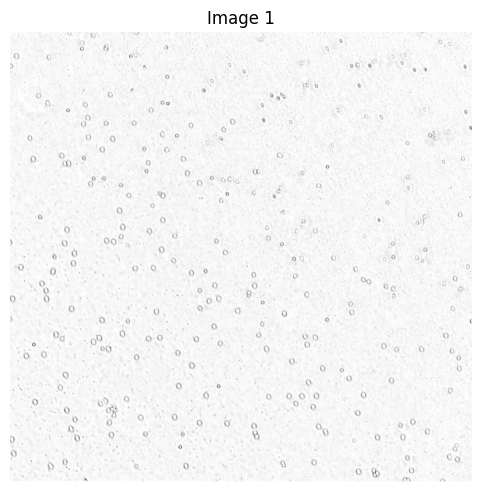

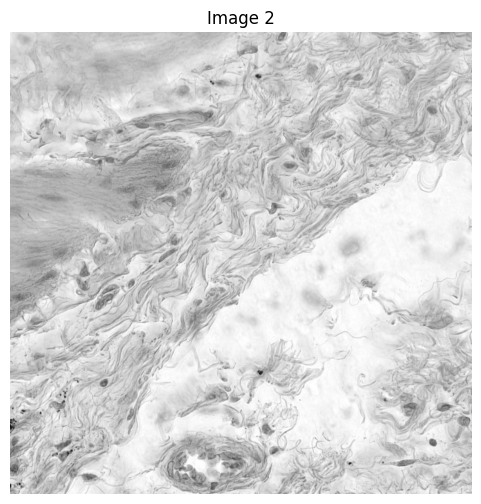

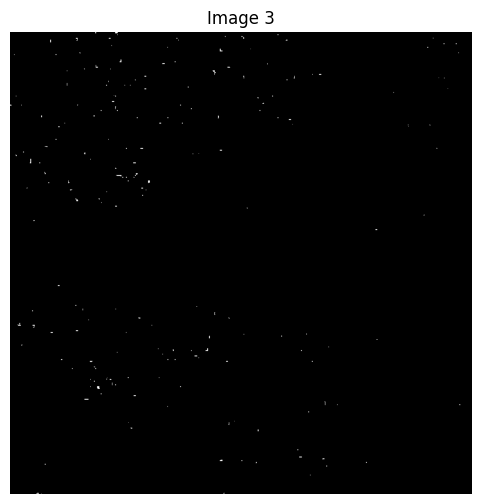

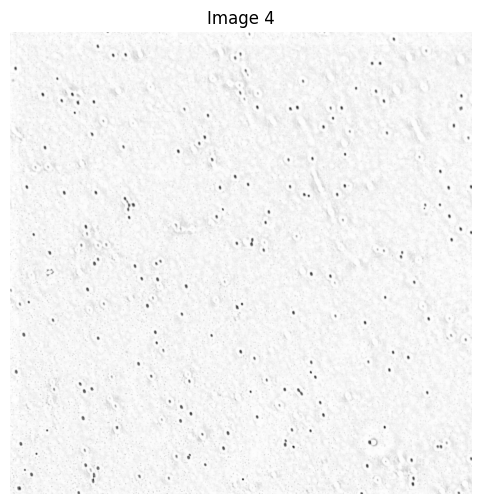

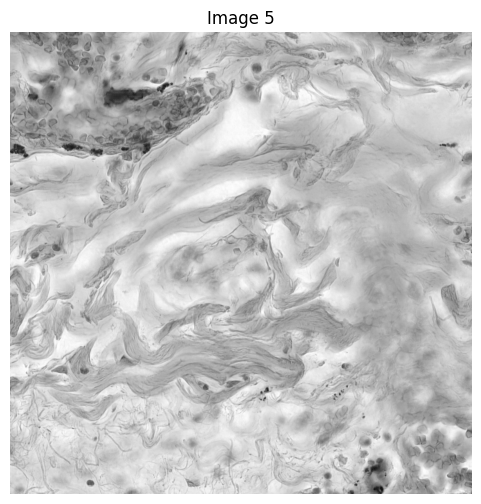

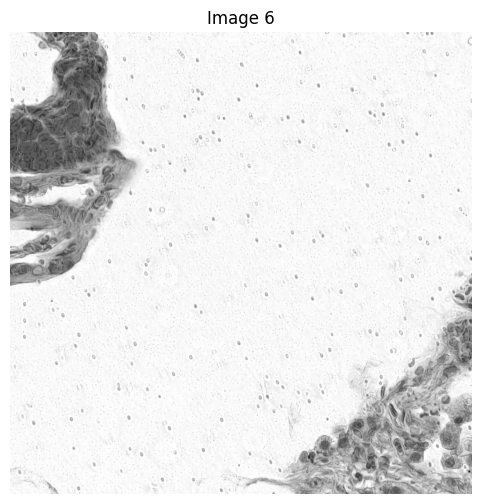

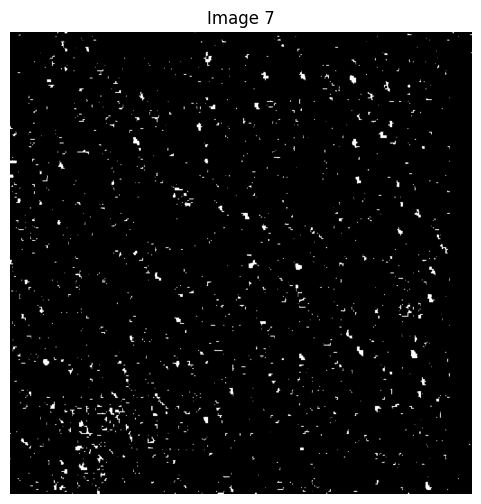

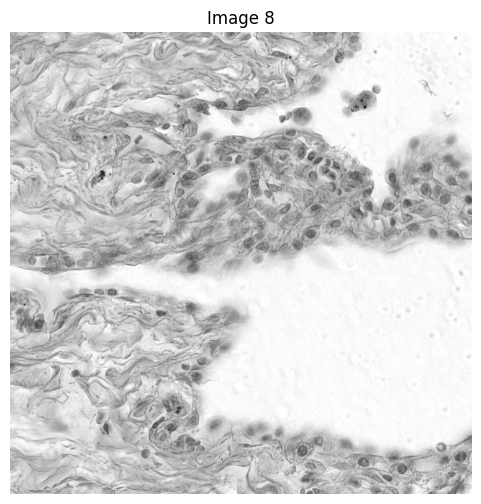

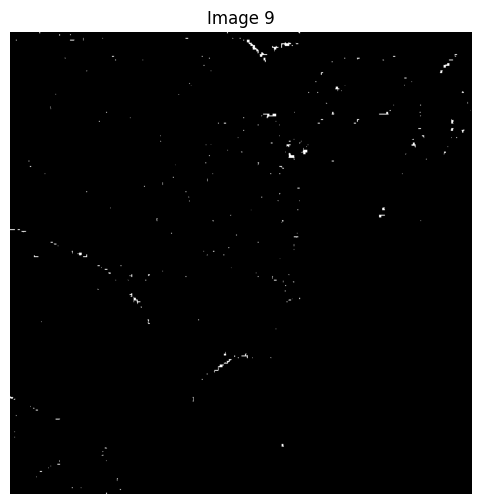

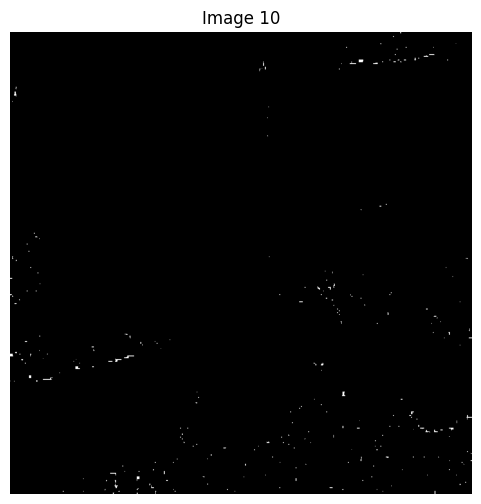

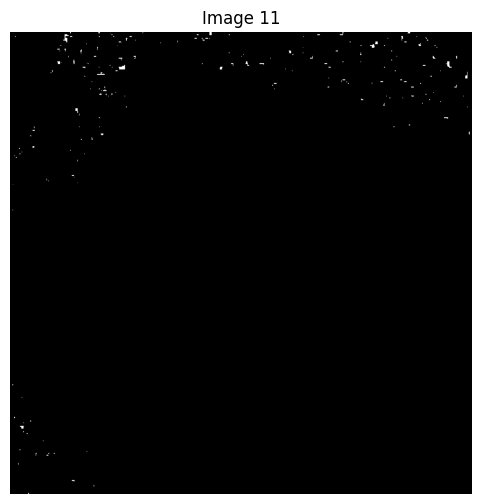

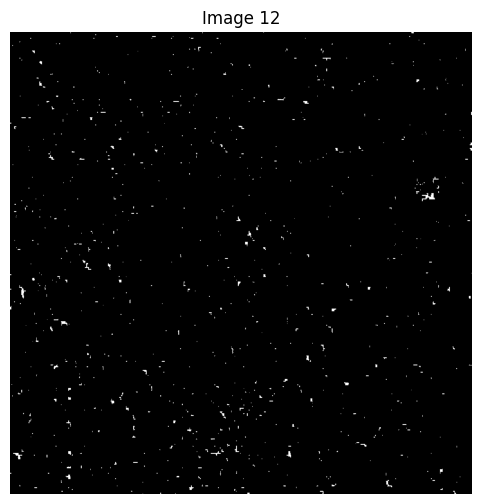

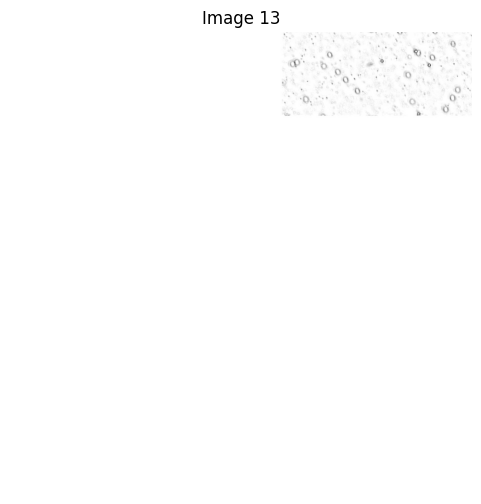

In [6]:
gray_images = []
for img in tqdm(valid_images):
    gray = grayscale(img)
    gray_images.append(gray)

show(gray_images)

In [7]:
# test
# _, binary = cv2.threshold(gray_images[1], 120, 255, cv2.THRESH_BINARY_INV)
# plt.imshow(binary, cmap='gray')


In [8]:
# plt.imshow(gray_images[1], cmap='gray')

In [9]:
# test
# thresholded =[]
# for i in tqdm(gray_images):
#     _, binary = cv2.threshold(i, 100, 255, cv2.THRESH_BINARY_INV)
#     thresholded.append(binary)
# show (thresholded)

In [10]:
#test
# def adaptive_threshold(img):
#     binary = cv2.adaptiveThreshold(
#         # img, 255,
#         cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#         cv2.THRESH_BINARY,
#         blockSize=35,  # window size
#         C=2             # subtractive constant
#     )
#     return binary
# plt.imshow(adaptive_threshold(img_test), cmap='gray')


In [11]:
def needs_inversion(binary_img):
    white_ratio = np.mean(binary_img > 128)
    return white_ratio > 0.5

In [12]:
def process_nuclei_images(gray_images):
    results = []
    for idx, img in enumerate(tqdm(gray_images)):     
        otsu_thresh_val, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        if needs_inversion(binary_otsu):
            binary_otsu = 255 - binary_otsu
        results.append({
            "index": idx,
            "otsu_threshold": otsu_thresh_val,
            "binary_image": binary_otsu
        })
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img, cmap='gray')
        axs[0].set_title(f"Original {idx}")
        axs[1].hist(img.ravel(), bins=256, range=(0, 256))
        axs[1].axvline(otsu_thresh_val, color='r', linestyle='--')
        axs[1].set_title(f"Histogram (Otsu={int(otsu_thresh_val)})")
        axs[2].imshow(binary_otsu, cmap='gray')
        axs[2].set_title("Otsu Binarized")
        for ax in axs:
            ax.axis('off' if ax != axs[1] else 'on')
        plt.tight_layout()
        plt.show()
    
    return results

  0%|          | 0/13 [00:00<?, ?it/s]

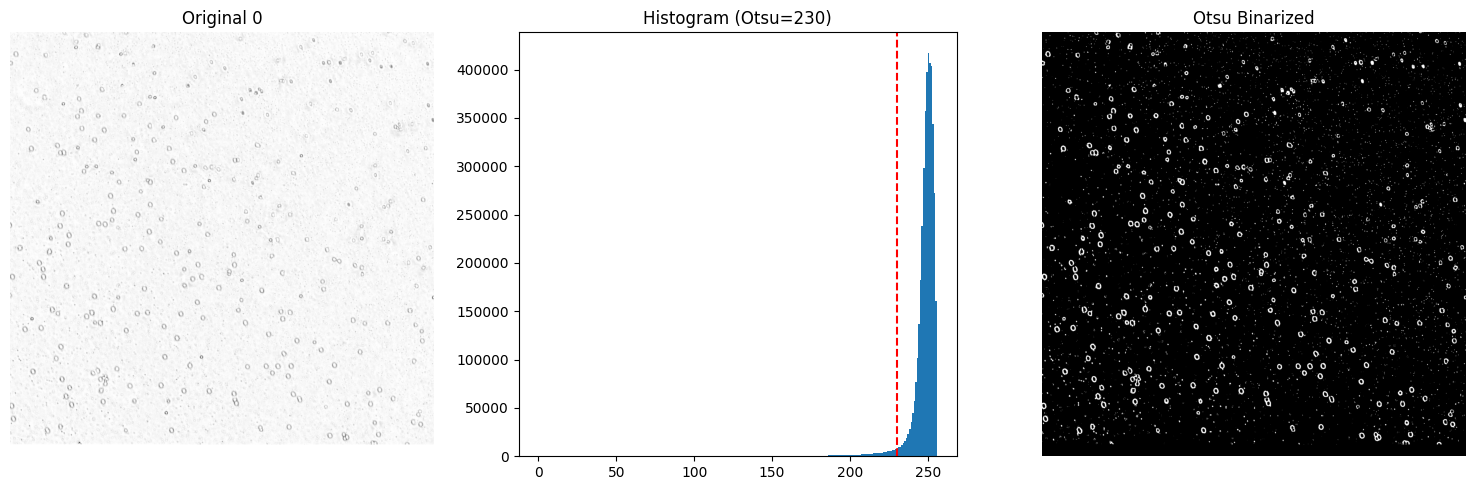

  8%|▊         | 1/13 [00:01<00:15,  1.32s/it]

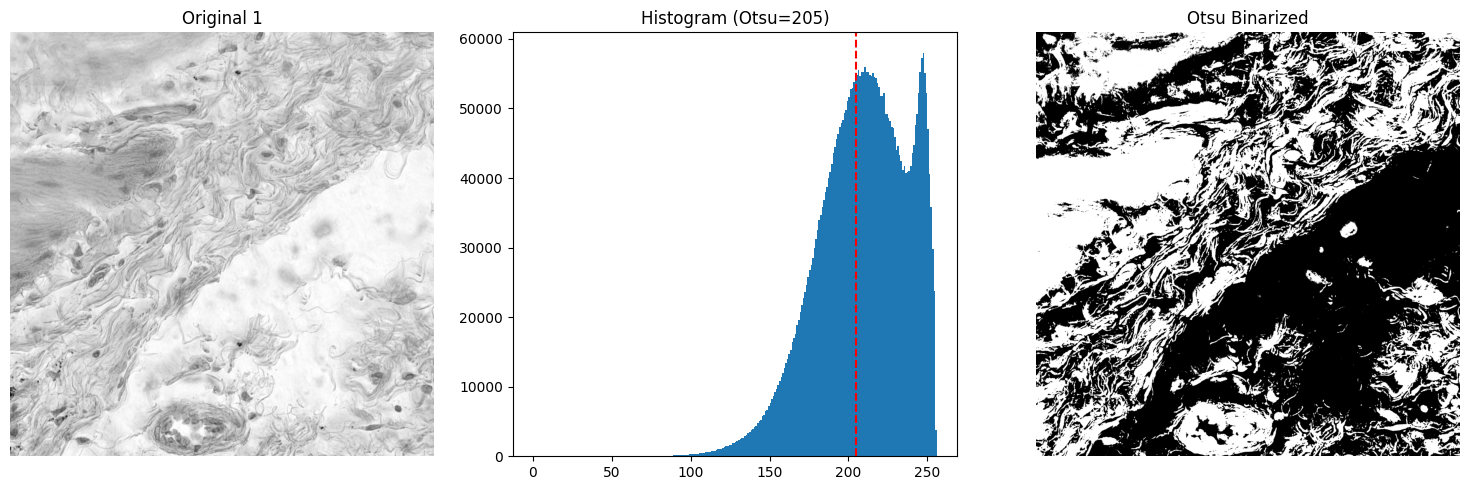

 15%|█▌        | 2/13 [00:02<00:14,  1.32s/it]

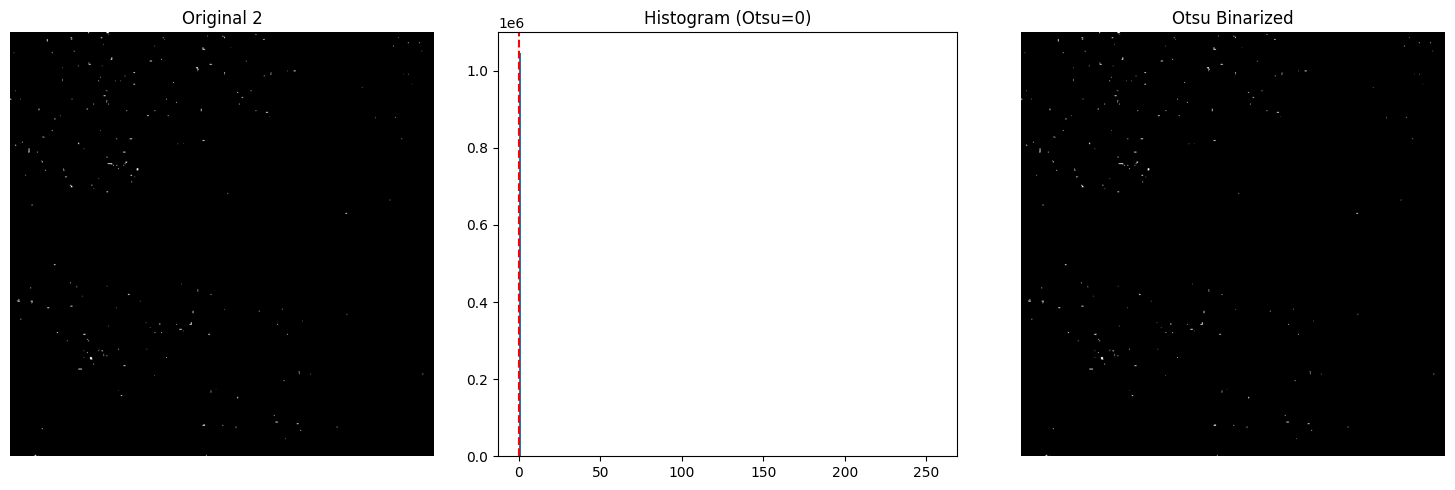

 23%|██▎       | 3/13 [00:03<00:09,  1.00it/s]

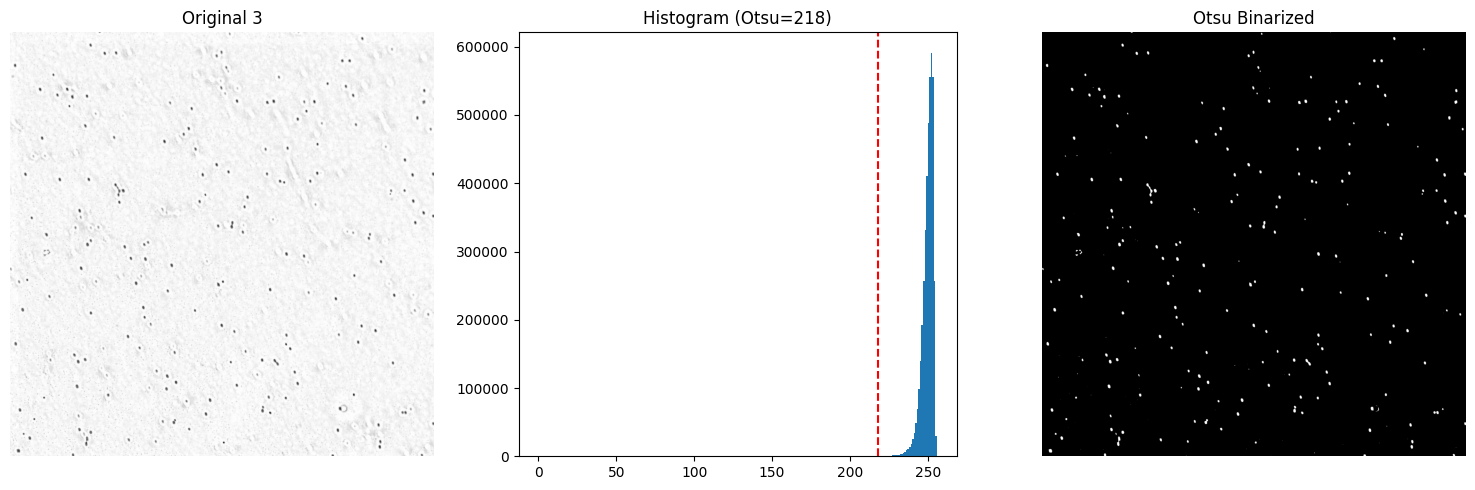

 31%|███       | 4/13 [00:04<00:09,  1.11s/it]

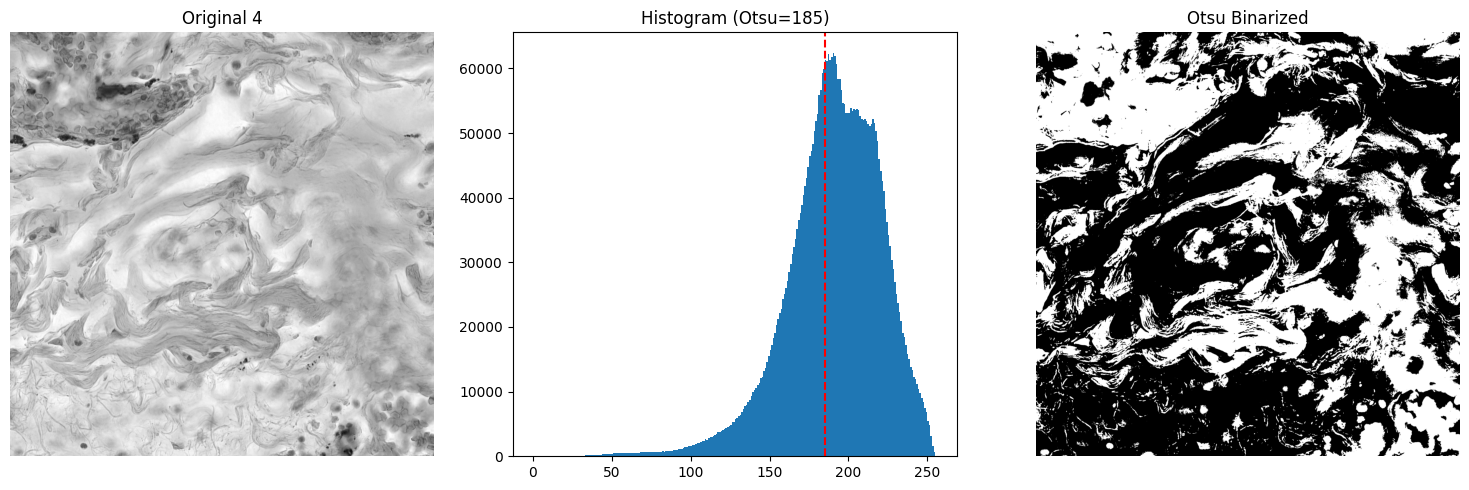

 38%|███▊      | 5/13 [00:06<00:10,  1.25s/it]

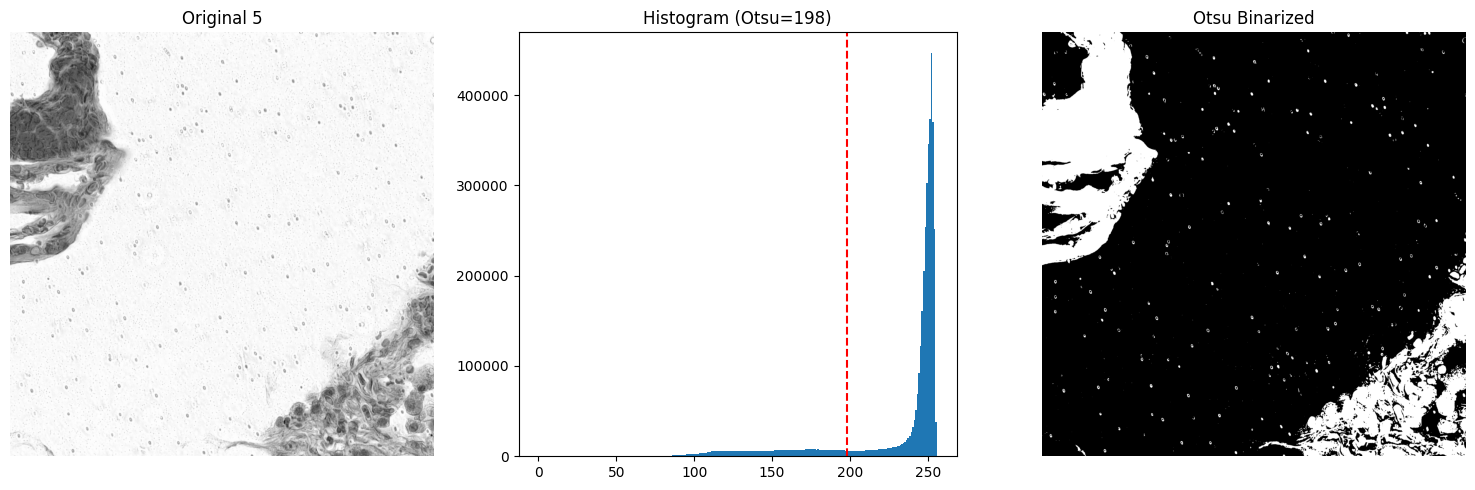

 46%|████▌     | 6/13 [00:07<00:08,  1.27s/it]

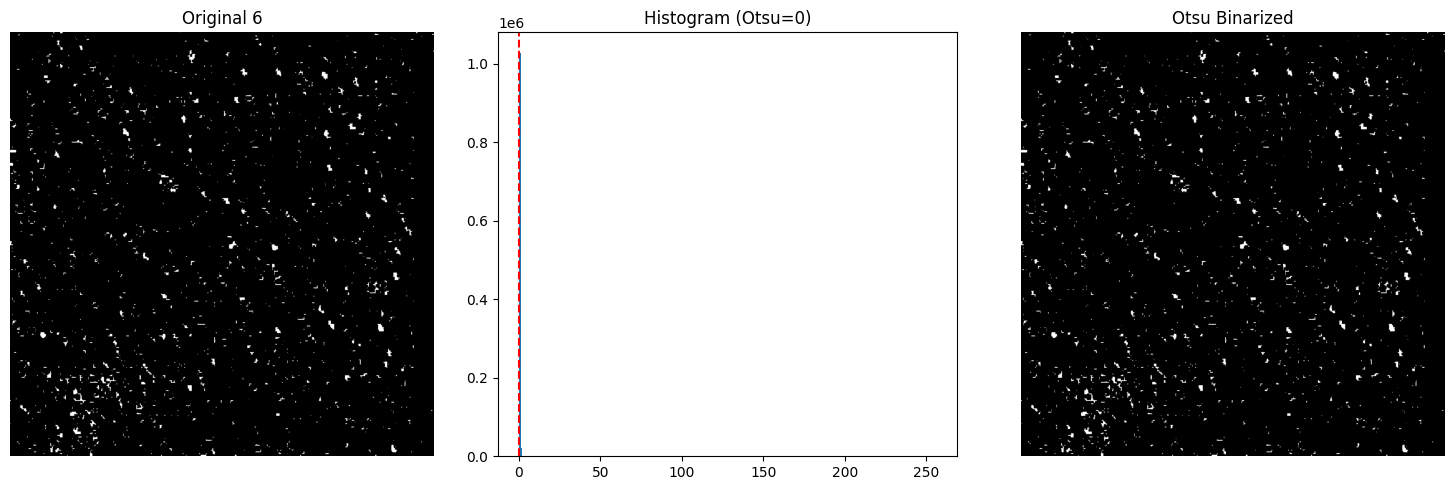

 54%|█████▍    | 7/13 [00:07<00:06,  1.05s/it]

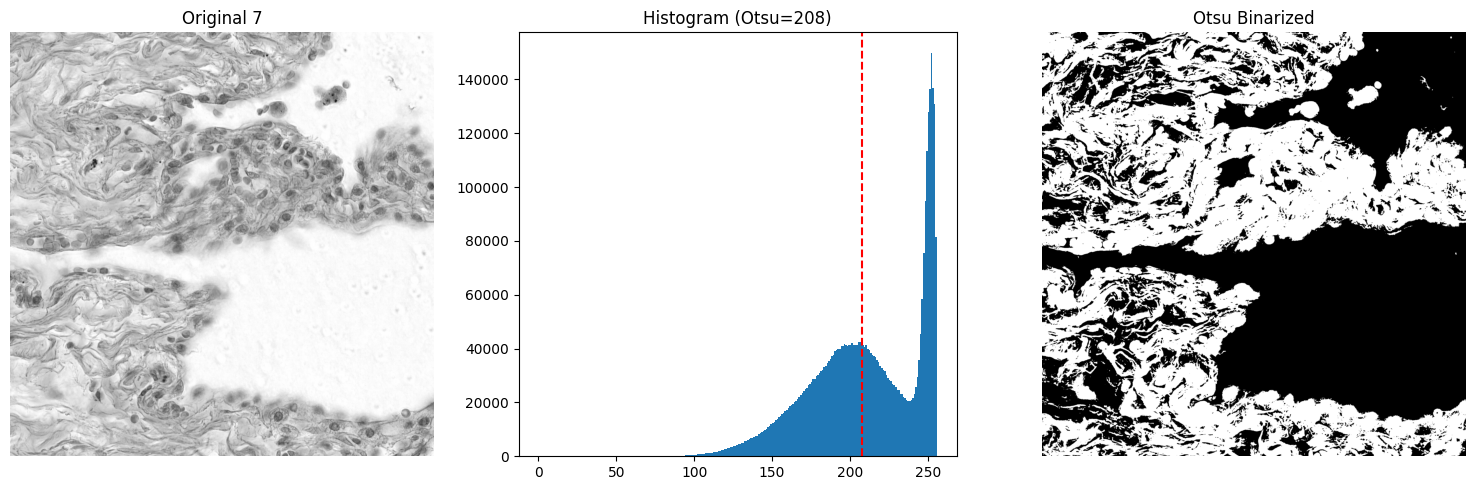

 62%|██████▏   | 8/13 [00:09<00:05,  1.16s/it]

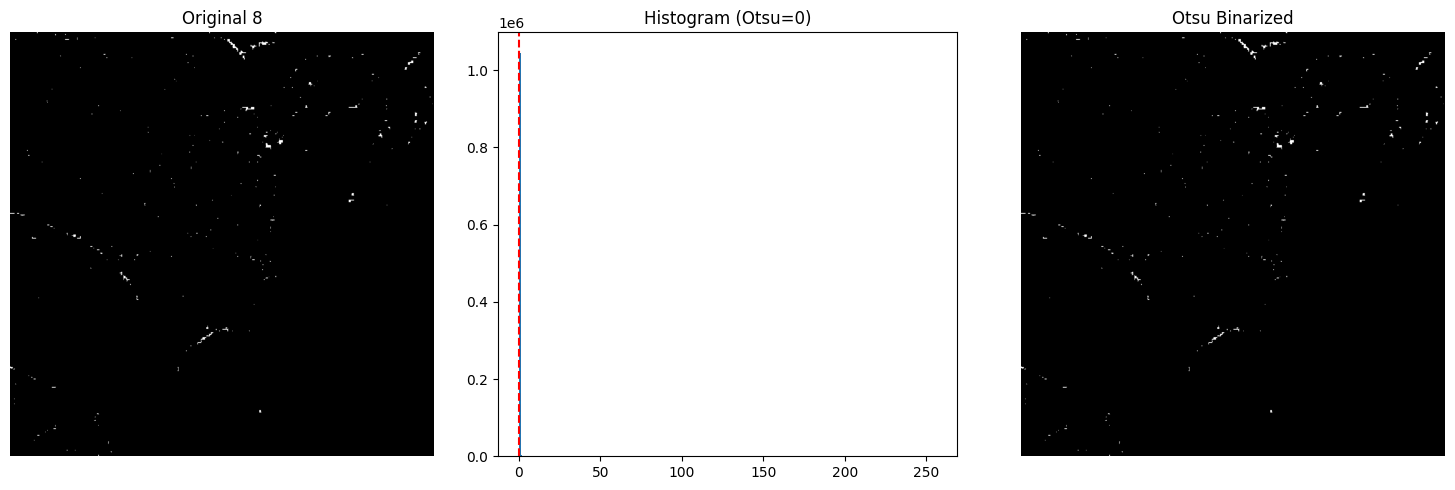

 69%|██████▉   | 9/13 [00:10<00:04,  1.03s/it]

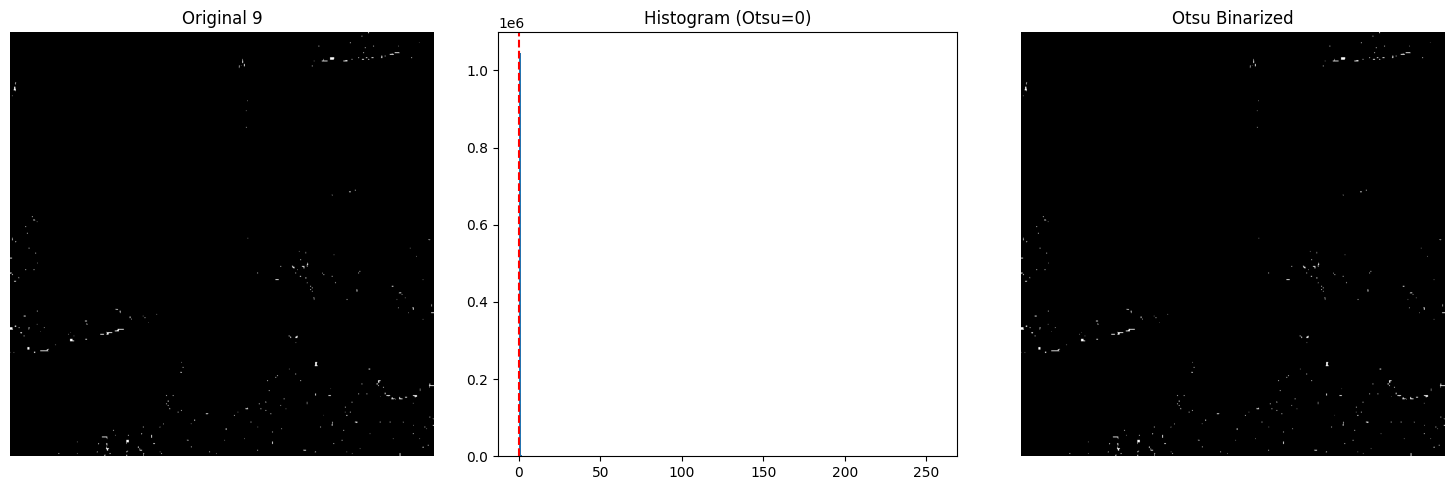

 77%|███████▋  | 10/13 [00:10<00:02,  1.13it/s]

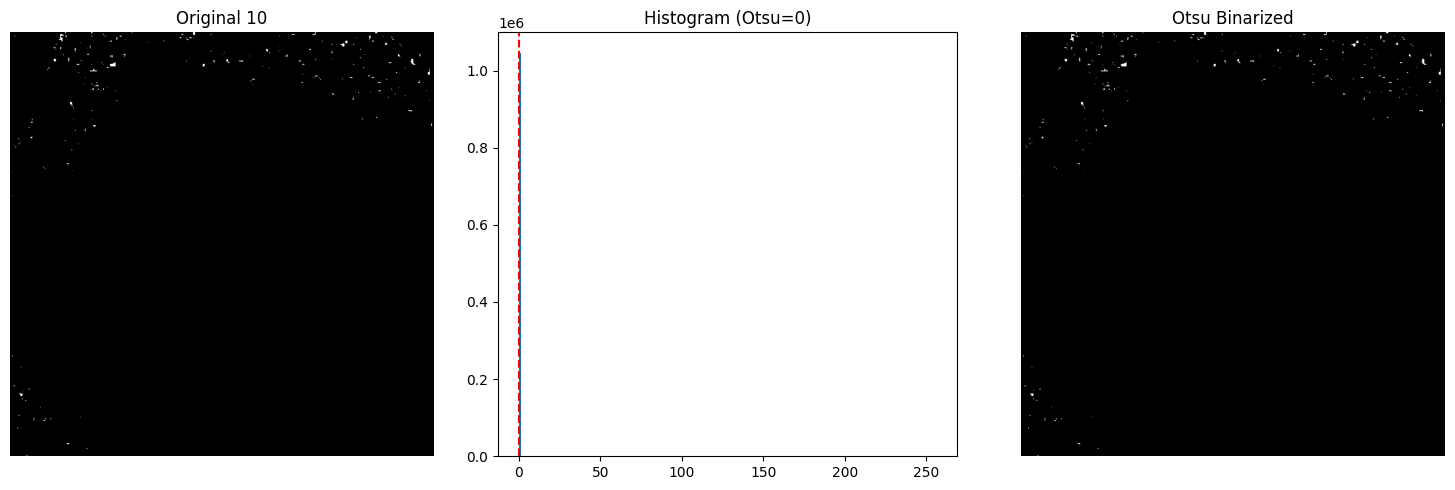

 85%|████████▍ | 11/13 [00:11<00:01,  1.25it/s]

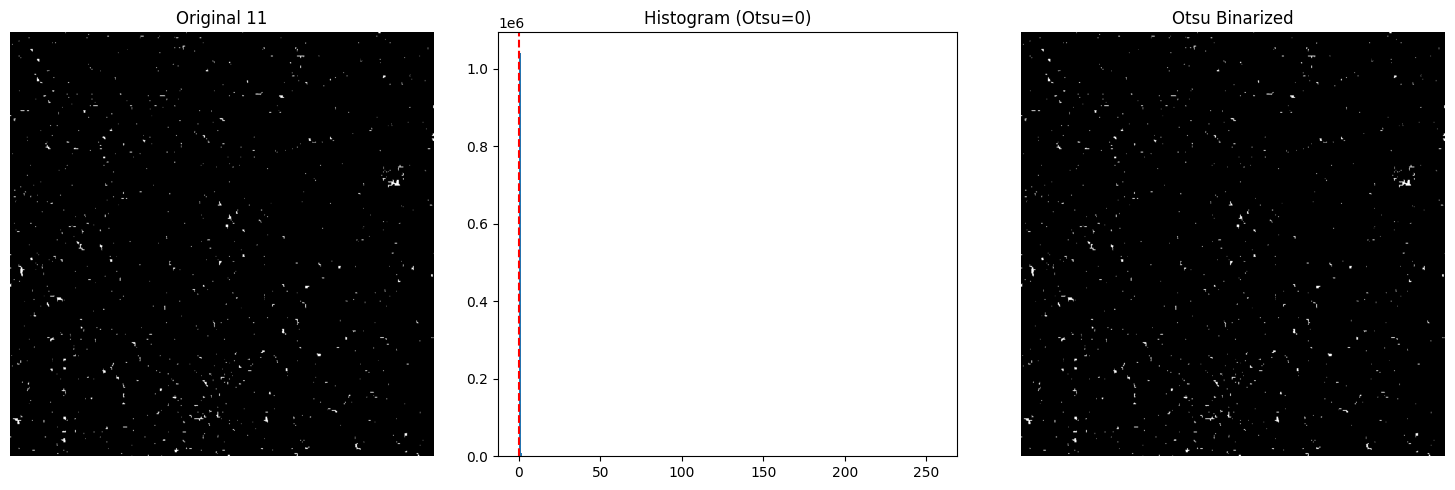

 92%|█████████▏| 12/13 [00:11<00:00,  1.35it/s]

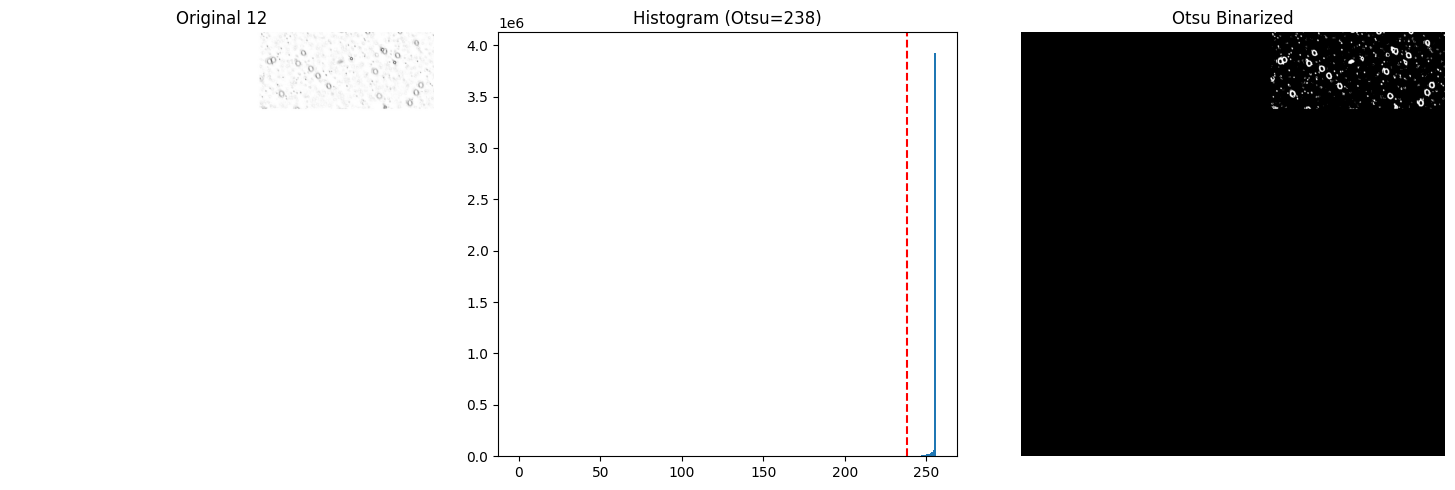

100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


In [13]:
thresholding_results = process_nuclei_images(gray_images)

In [14]:
def clean_binary(binary_img, min_area=25, max_area=500, max_eccentricity=0.95):

    labels = measure.label(binary_img, connectivity=2)
    props = measure.regionprops(labels)
    
    cleaned = np.zeros_like(binary_img, dtype=np.uint8)

    for prop in props:
        if min_area < prop.area < max_area and prop.eccentricity < max_eccentricity:
            cleaned[labels == prop.label] = 255
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)

    return cleaned

100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


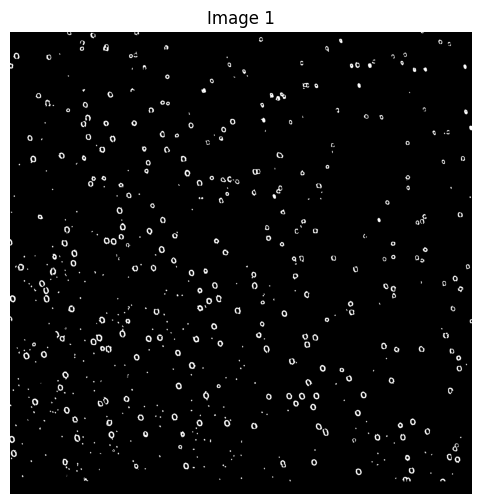

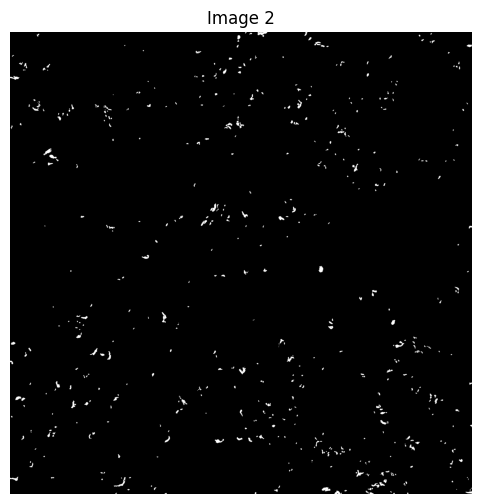

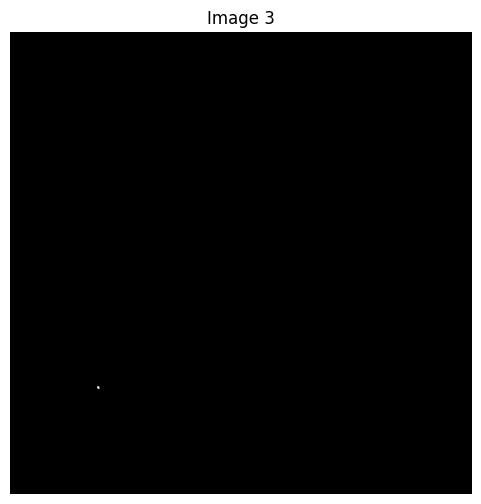

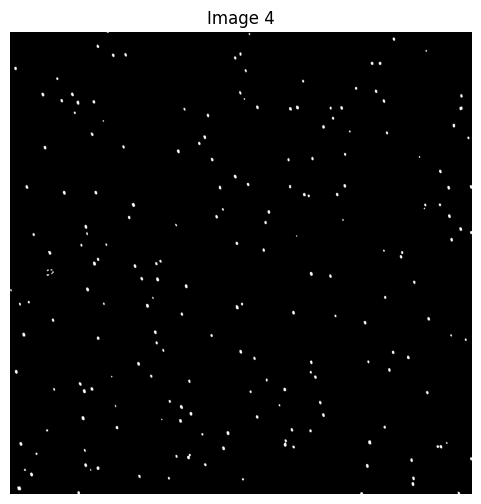

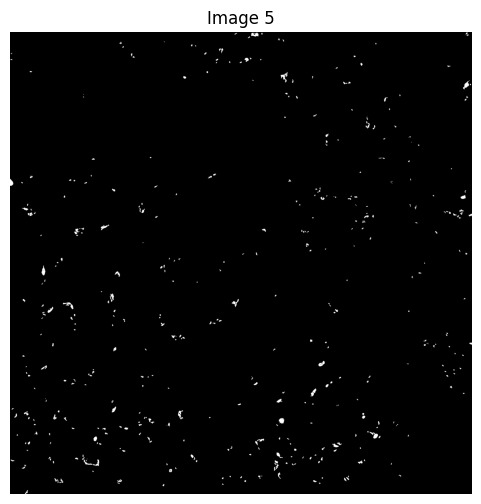

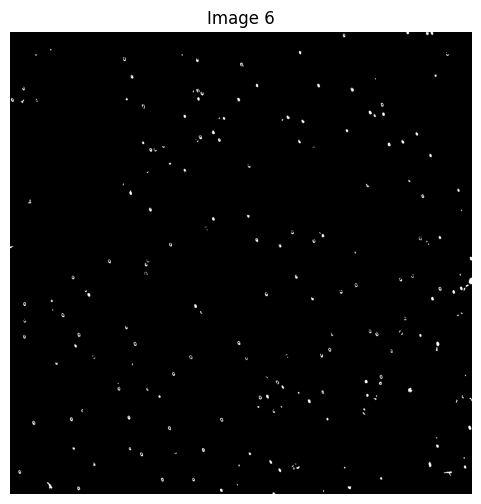

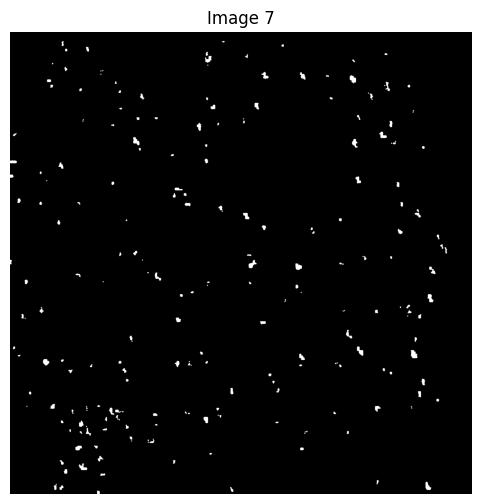

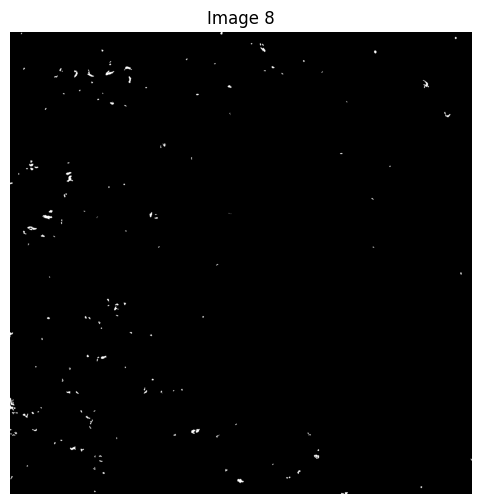

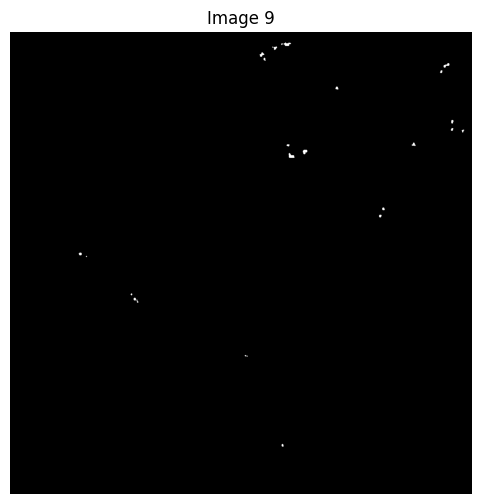

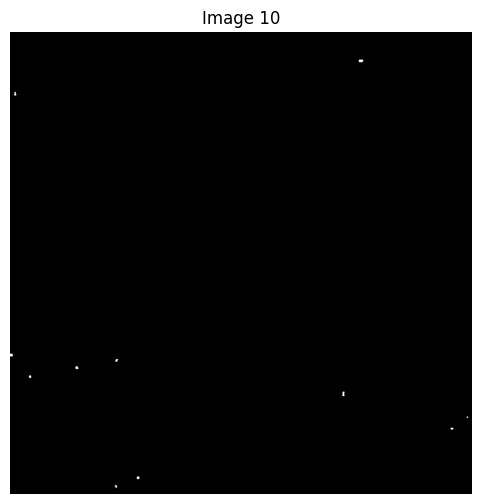

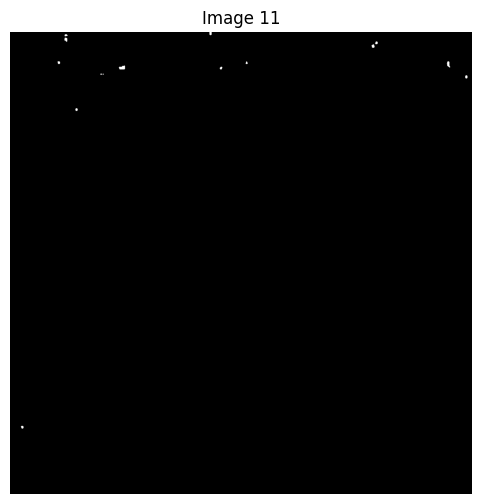

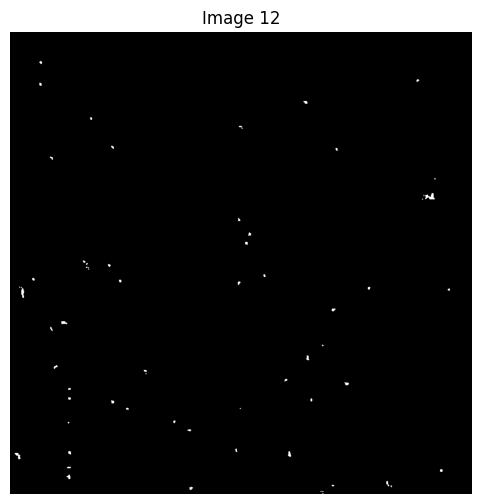

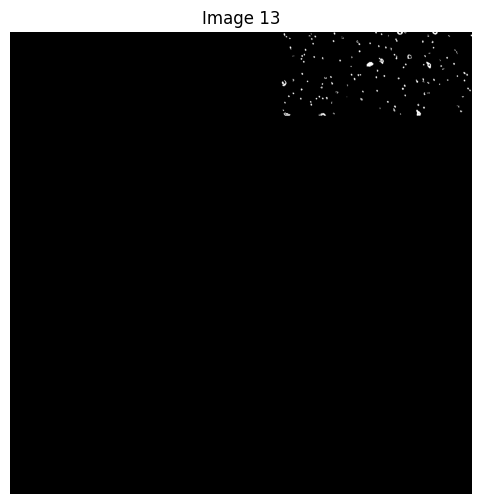

In [15]:
cleaned_images = [clean_binary(img_dict['binary_image']) for img_dict in tqdm(thresholding_results)]
show(cleaned_images)

In [16]:
labeled_images = [measure.label((img > 0).astype(np.uint8), connectivity=2) for img in cleaned_images]

In [17]:
def plot_labeled_mask_with_centroids(label_img):
    props = measure.regionprops(label_img)
    overlay = color.label2rgb(label_img, bg_label=0)
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.axis('off')
    for p in props:
        y, x = p.centroid
        plt.plot(x, y, 'ro', markersize=1)
    plt.title(f"Labeled nuclei with dots (n={len(props)})")
    plt.show()
    return len(props) 

  0%|          | 0/13 [00:00<?, ?it/s]

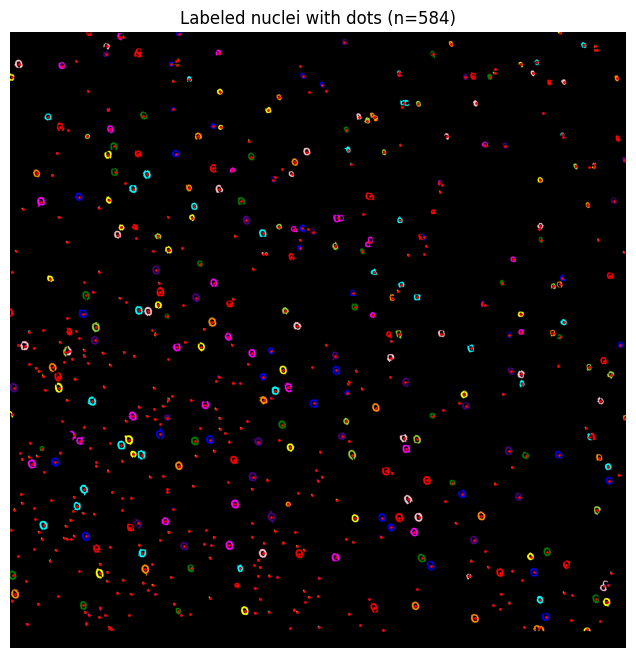

  8%|▊         | 1/13 [00:01<00:13,  1.13s/it]

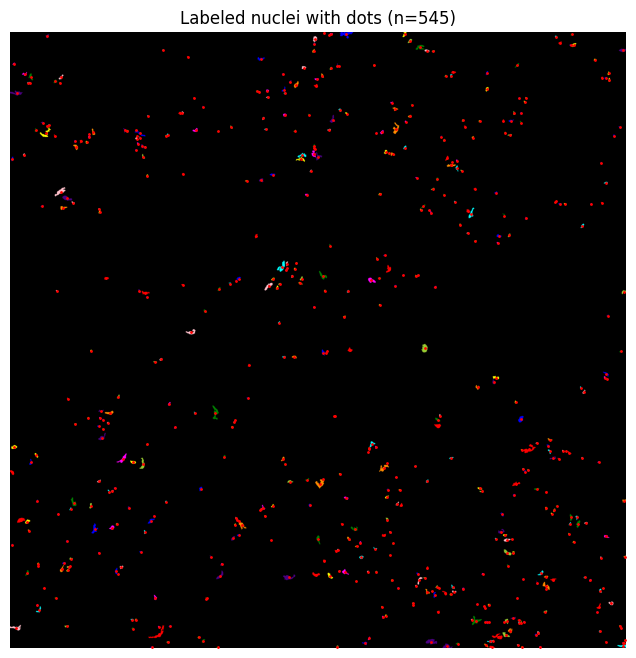

 15%|█▌        | 2/13 [00:02<00:11,  1.04s/it]

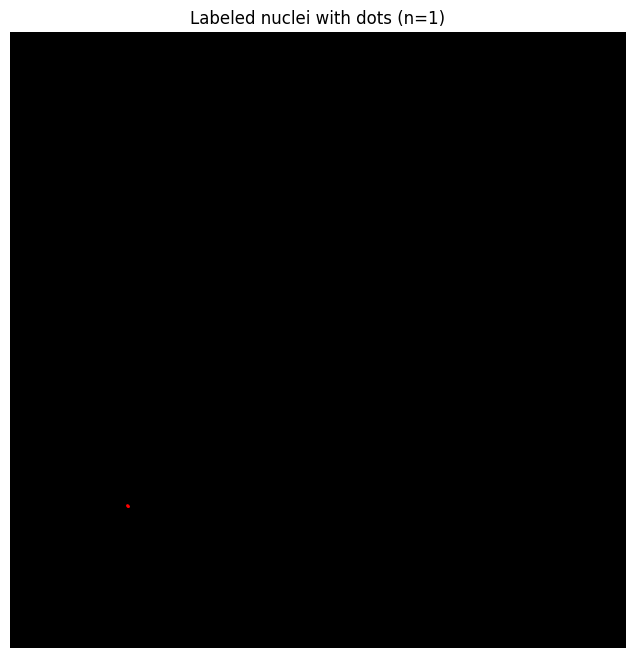

 23%|██▎       | 3/13 [00:02<00:06,  1.49it/s]

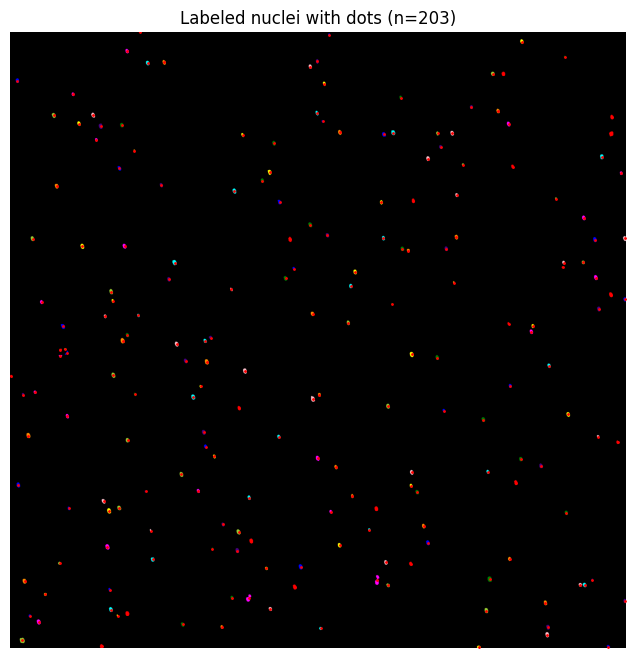

 31%|███       | 4/13 [00:03<00:07,  1.26it/s]

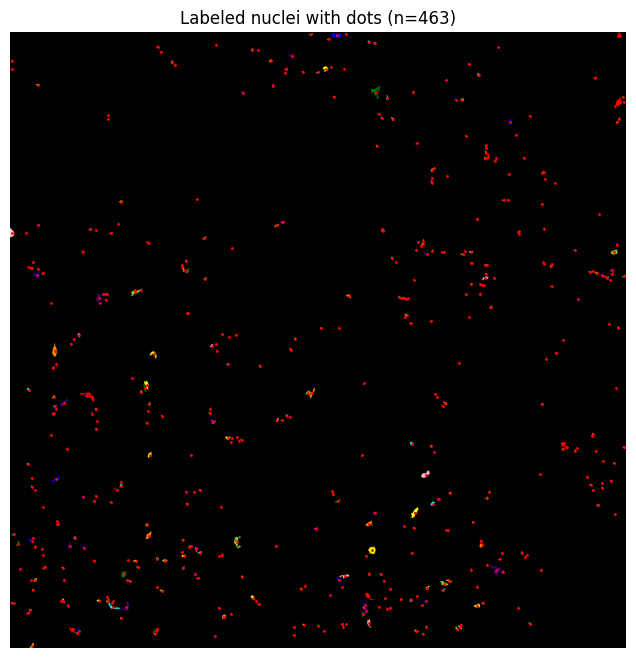

 38%|███▊      | 5/13 [00:04<00:06,  1.20it/s]

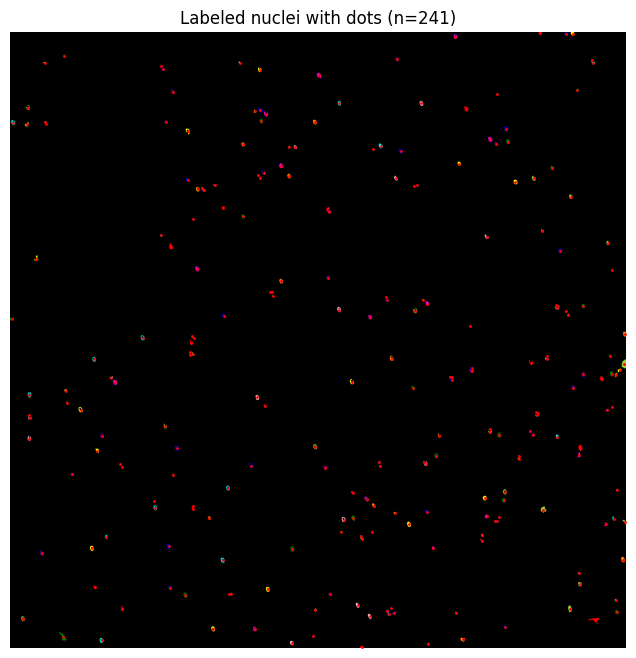

 46%|████▌     | 6/13 [00:04<00:05,  1.26it/s]

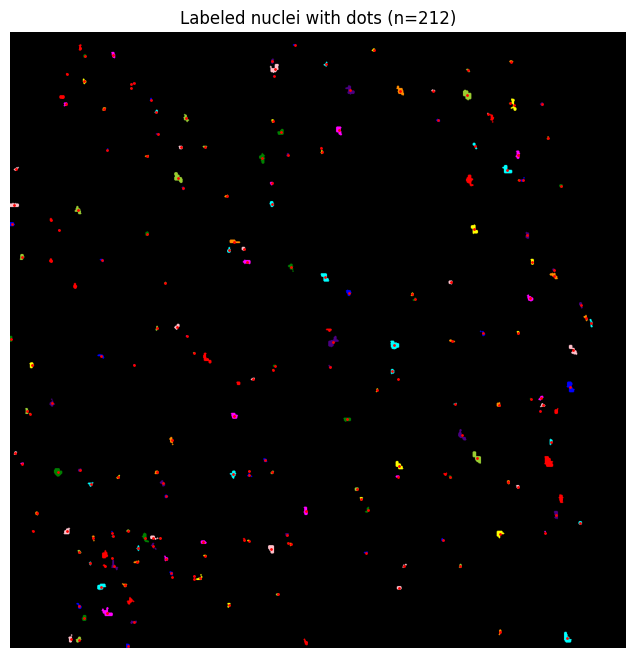

 54%|█████▍    | 7/13 [00:05<00:03,  1.57it/s]

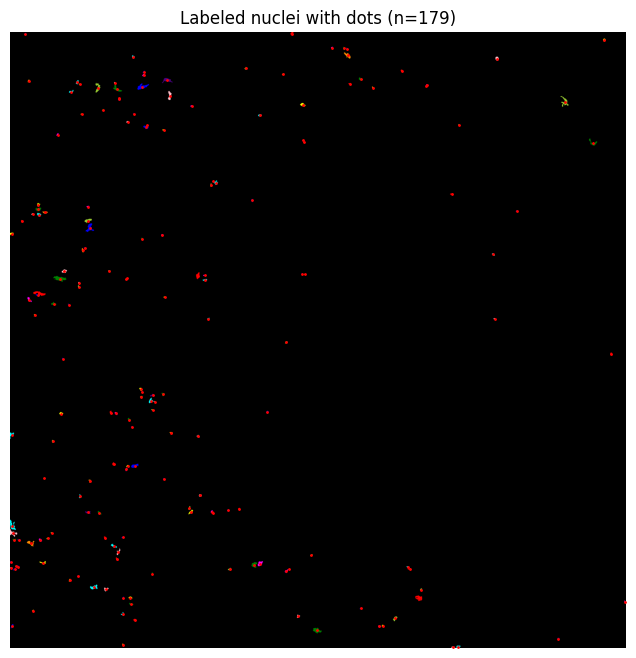

 62%|██████▏   | 8/13 [00:06<00:03,  1.42it/s]

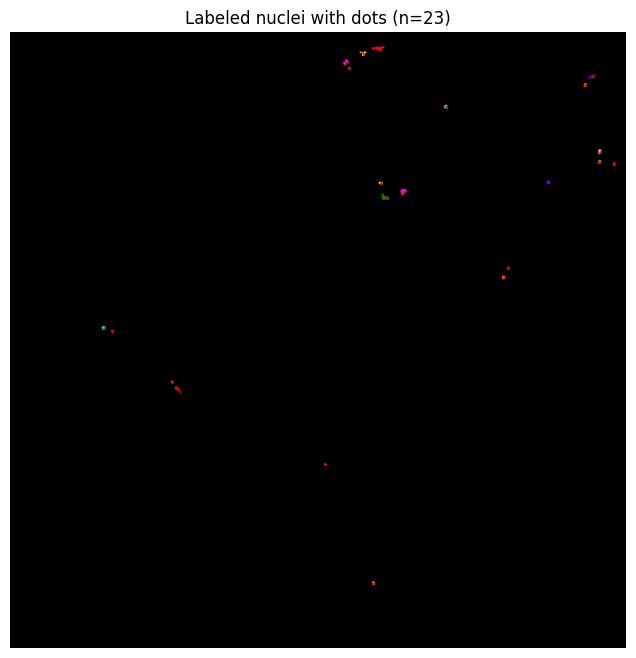

 69%|██████▉   | 9/13 [00:06<00:02,  1.82it/s]

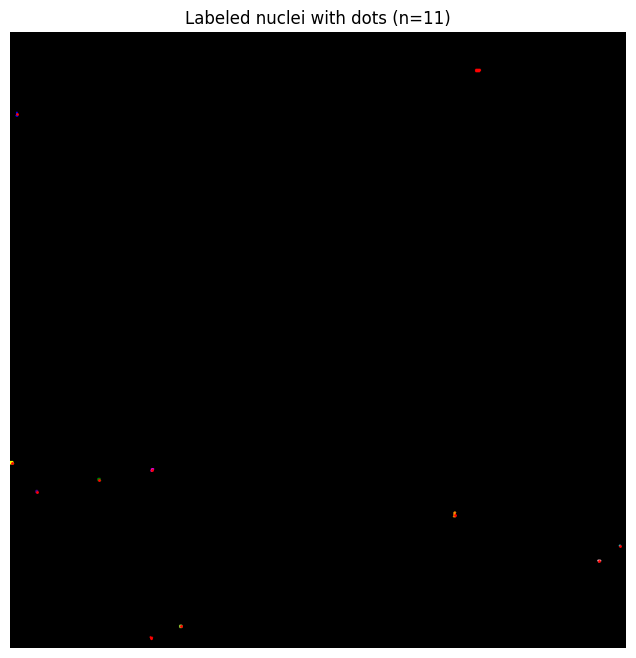

 77%|███████▋  | 10/13 [00:06<00:01,  2.27it/s]

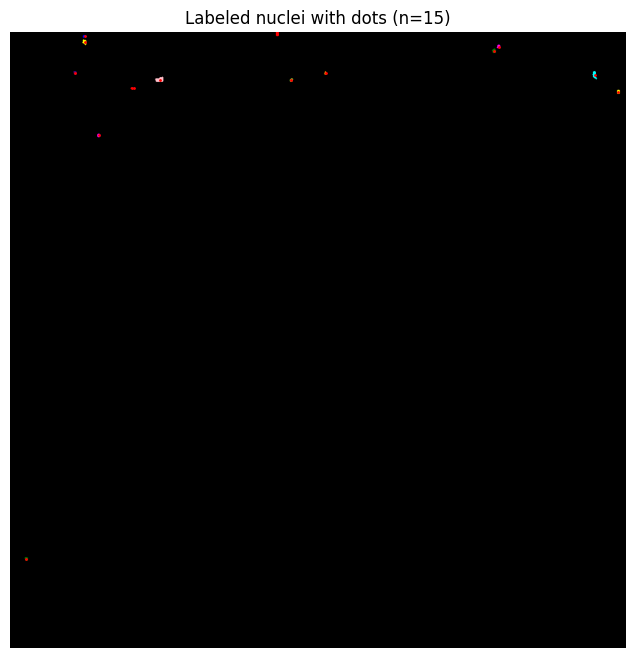

 85%|████████▍ | 11/13 [00:06<00:00,  2.71it/s]

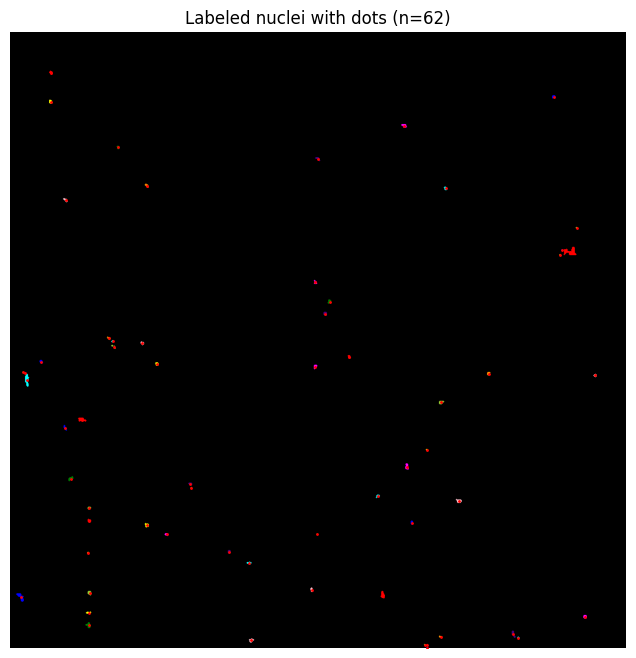

 92%|█████████▏| 12/13 [00:06<00:00,  3.02it/s]

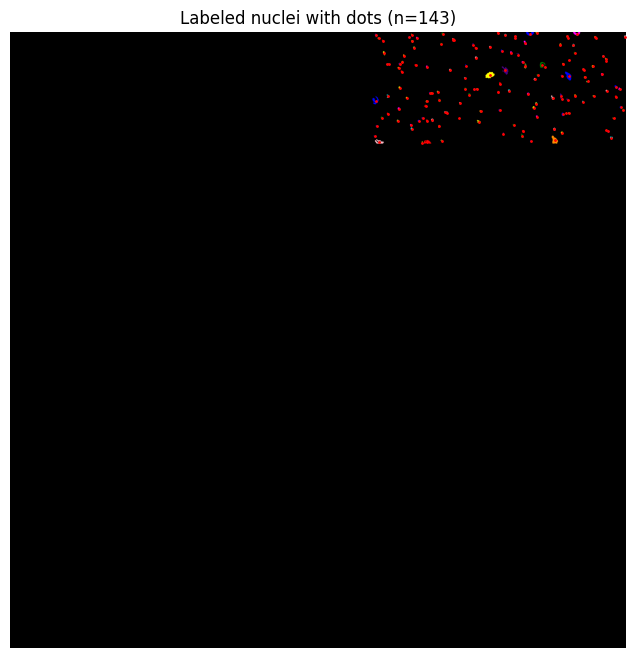

100%|██████████| 13/13 [00:07<00:00,  1.71it/s]

Average number of cells per image: 206.3


In [18]:
cell_counts = [plot_labeled_mask_with_centroids(label_img) for label_img in tqdm(labeled_images)]
print(f"Average number of cells per image: {np.mean(cell_counts):.1f}")